<a href="https://colab.research.google.com/github/adifatol/BIQA/blob/master/convNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [1]:
!ls blur

ls: cannot access 'blur': No such file or directory


# Upload Images

shows a dialog to upload new images

option to download the CSIQ Image Quality Database

In [0]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [3]:
!wget http://vision.eng.shizuoka.ac.jp/csiq/src_imgs.zip
!wget http://vision.eng.shizuoka.ac.jp/csiq/dst_imgs.zip
  
!unzip -n src_imgs.zip
!unzip -n dst_imgs.zip

--2019-05-07 11:57:06--  http://vision.eng.shizuoka.ac.jp/csiq/src_imgs.zip
Resolving vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)... 133.70.150.170
Connecting to vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)|133.70.150.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14455692 (14M) [application/zip]
Saving to: ‘src_imgs.zip’

src_imgs.zip        100%[===================>]  13.79M  9.85MB/s    in 1.4s    

2019-05-07 11:57:08 (9.85 MB/s) - ‘src_imgs.zip’ saved [14455692/14455692]

--2019-05-07 11:57:11--  http://vision.eng.shizuoka.ac.jp/csiq/dst_imgs.zip
Resolving vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)... 133.70.150.170
Connecting to vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)|133.70.150.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374383009 (357M) [application/zip]
Saving to: ‘dst_imgs.zip’

dst_imgs.zip        100%[===================>] 357.04M  11.2MB/s    in 32s     

2019-05-07 1

# Load Images in colab

loads images of a certain SHAPE into runtime memory

In [4]:

import os

# List Image Names
# Parses each file name of format <NAME>.png
# TODO: support for other extensions?
def image_list( ext = '.png'):
  names = {}
  for f in [file for file in os.listdir() if file.endswith(ext)]:
    fname = os.path.splitext(f)[0]
    names[fname] = 1
  return list(names.keys())

img_list = image_list()
print('Images found: ', img_list)

Images found:  ['bridge', 'boston', 'geckos', 'child_swimming', 'woman', '1600', 'couple', 'family', 'sunset_sparrow', 'lady_liberty', 'trolley', 'rushmore', 'snow_leaves', 'veggies', 'elk', 'aerial_city', 'foxy', 'roping', 'log_seaside', 'turtle', 'native_american', 'fisher', 'monument', 'cactus', 'shroom', 'redwood', 'sunsetcolor', 'lake', 'butter_flower', 'swarm']


In [5]:

# Load the images
# Encode them into jpg

DISTORT = ['blur','contrast','fnoise', 'jpeg', 'jpeg2000']
DISTORT_EXT = ['BLUR','contrast','fnoise', 'JPEG', 'jpeg2000']
Q_LEVELS = ['1','2','3','4','5']

from random import randint
import numpy as np
import cv2

#TODO support for nItems = 'ALL'
#TODO support various loading order (randomize?)
def load_imgs(img_list, nItems = 5):
  images = {}
  images['orig'] = []
  for dist in DISTORT:
    images[dist] = {}
    for qlvl in Q_LEVELS:
      images[dist][qlvl] = []

  for f in range(0,nItems):
    fname = img_list[f]
    original = fname+'.png'
    img_data = cv2.imread(original)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    images['orig'].append(img_data)
    for dist, d_ext in zip(DISTORT, DISTORT_EXT):
      for qlvl in Q_LEVELS:
        f_path = dist+'/'+fname+'.'+d_ext+'.'+qlvl+'.png'
        img_data = cv2.imread(f_path)
        img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
        images[dist][qlvl].append(img_data)
  return images

images = load_imgs(img_list, 3)

print("Nr of img:",len(images['orig']))


Nr of img: 3


In [0]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_all(arr_of_images, patch_estimator=False):
  columns = 5
  spacing = 14.75
  minorLocator = MultipleLocator(spacing)
  fig = plt.figure(figsize=(20,10))
  for i, image in enumerate(arr_of_images):
    ax = fig.add_subplot(len(images) / columns + 1, columns, i + 1)
    if patch_estimator:
      ax.yaxis.set_minor_locator(minorLocator)
      ax.xaxis.set_minor_locator(minorLocator)
      ax.grid(which = 'minor')
    plt.imshow(image)
  plt.show()


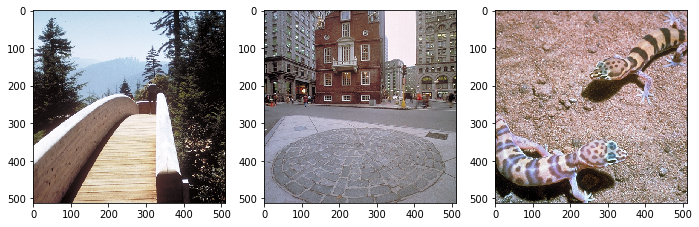

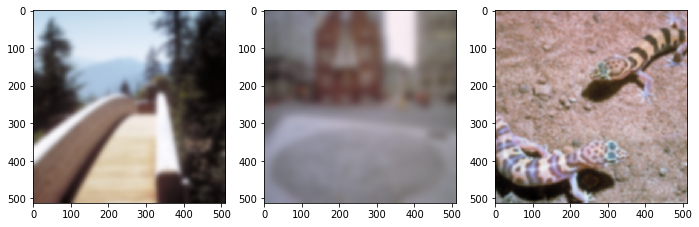

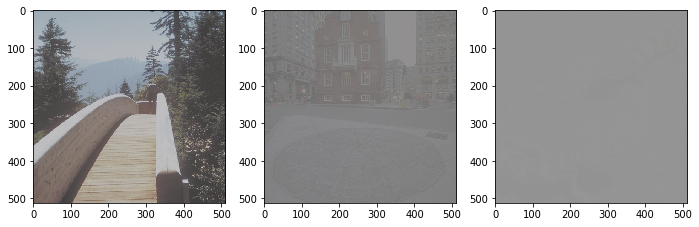

In [7]:
#Print some stats

rand_idx = randint(0, len(images['orig'])-3)
plot_all(images['orig'][rand_idx:rand_idx+3])
plot_all(images['blur']['5'][rand_idx:rand_idx+3])
plot_all(images['contrast']['5'][rand_idx:rand_idx+3])


# Score Images

apply the method suggested in [Learning without Human Scores for Blind Image Quality Assessment](https://www.cv-foundation.org/openaccess/content_cvpr_2013/papers/Xue_Learning_without_Human_2013_CVPR_paper.pdf)

## Extract Patches and calculate {SSIM} score

In [8]:
!pip install tqdm

In [9]:
from skimage.measure import compare_ssim
from skimage.util.shape import view_as_windows
from tqdm import tqdm

WH=15
WINDOW_SHAPE = (WH,WH,3)
PATCH_COUNT = 1156 #TODO this should be automated somehow

def plot_patches(patches):
  w=10
  h=10
  fig=plt.figure(figsize=(8, 8))
  columns = 1
  rows = 1
  for i in range(1, columns*rows +1):
      img = patches[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()

def extract_patches(img):
  patches = np.squeeze(view_as_windows(img, WINDOW_SHAPE,step=WH))
  patches = np.reshape(patches,(-1,15,15,3))
  return patches

dim_len, dim_dist, dim_q = len(images['orig']), len(DISTORT), len(Q_LEVELS);
test_len = dim_len

one_score = [[np.zeros(PATCH_COUNT) for x in range(dim_dist)] for y in range(dim_q)]
scores = [np.copy(one_score) for x in range(test_len)]
all_patches = []

for i in tqdm(range(len(images['orig'][:test_len]))):
  img = images['orig'][i]
  orig_patches = extract_patches(img)
  for idist, dist in enumerate(DISTORT):
    for iqlvl, qlvl in enumerate(Q_LEVELS):
      dist_img = images[dist][qlvl][i]
      distorted_patches = extract_patches(dist_img)
      local_scores = np.zeros(PATCH_COUNT)
      local_patches = []
      for j in range(PATCH_COUNT):
        orig_patch = orig_patches[j]
        dist_patch = distorted_patches[j]
        (score, diff) = compare_ssim(orig_patch, dist_patch, full=True, multichannel=True)
        local_scores[j] = score
        all_patches.append(dist_patch)
      scores[i][idist][iqlvl] = np.copy(local_scores)

#   plot_patches(orig_patches)
#   for patch in orig_patches:
#   (score, diff) = compare_ssim(dist_img, img, full=True, multichannel=True)
#   diff = (diff * 255).astype("uint8")
#   print("___")
#   print("SSIM: {}".format(score))


100%|██████████| 3/3 [01:12<00:00, 24.24s/it]


## Calculate the C constant (![alt text](https://latex.codecogs.com/gif.latex?c%20%3D%20%5Cfrac%7B%5Csum%20_%7Bi%5Cepsilon%20%5COmega%7DS_%7Bi%7D%20%7D%7B10*%5Csum%20_%7Bi%5Cepsilon%20%5COmega_%7Bp%7D%7DS_%7Bi%7D%7D))

In [0]:
def the_C_constant(batch):
  all_sum = sum(batch)
  percentile10 = np.percentile(batch,10)
  omega_p_sum = sum([i for i in batch if i <= percentile10])
  c = all_sum / (10 * omega_p_sum)
  return c
# the_C_constant(scores[0][0][0])

## Histograms for scores

(3, 5, 5, 1156)
1.0034851206409219
comparing for 2
(img-2 dist-0 qual-0)
[0.99569209 0.99598855 0.99576554 ... 0.99050649 0.99427265 0.99175835]


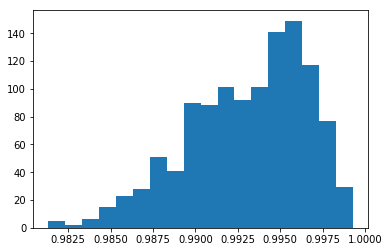

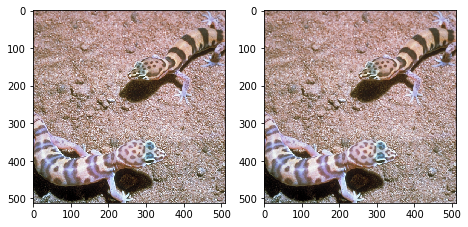

In [11]:
#Random scores visualisations

from mpl_toolkits.mplot3d import Axes3D

def histogram(img_idx, img_dist, img_qual):
  print("comparing for {}".format(img_idx))
  print("(img-{} dist-{} qual-{})".format(img_idx, img_dist, img_qual))
  print(scores[img_idx][img_dist][img_qual])
  plt.hist(scores[img_idx][img_dist][img_qual], bins='auto')
  plt.show()

ri = randint(0,dim_len-1)
rd = randint(0,dim_dist-1)
rq = randint(0,dim_q-1)

print(np.array(scores).shape)

for i in range(ri,ri+1):
  for d in range(rd,rd+1):
    for q in range(rq,rq+1):
      c = the_C_constant(scores[i][d][q])
      print(c)
      histogram(ri,rd,rq)
      plot_all([images['orig'][i],images[DISTORT[rd]][Q_LEVELS[rq]][ri]])


## Normalize scores

In [0]:
norm_scores = np.copy(scores)
all_scores = []
for i in range(0,dim_len):
  for d in range(0,dim_dist):
    for q in range(0,dim_q):
      c = the_C_constant(scores[i][d][q])
      norm_scores[i][d][q][:] = [x / c for x in norm_scores[i][d][q]]
      all_scores.extend(norm_scores[i][d][q])


(img-2 dist-blur qual-1)


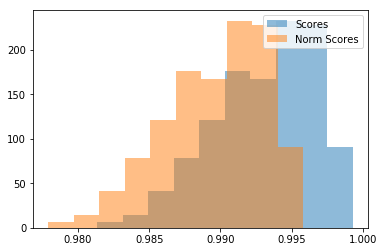

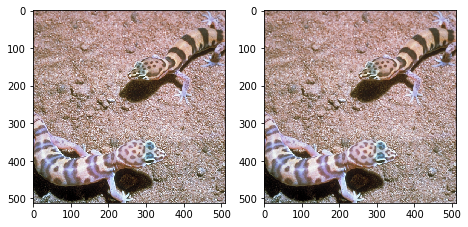

In [13]:
print("(img-{} dist-{} qual-{})".format(ri, DISTORT[rd], Q_LEVELS[rq]))

plt.hist(scores[ri][rd][rq], alpha=0.5, label='Scores')
plt.hist(norm_scores[ri][rd][rq], alpha=0.5, label='Norm Scores')
plt.legend(loc='upper right')
plt.show()

plot_all([images['orig'][ri],images[DISTORT[rd]][Q_LEVELS[rq]][ri]])

## Score QAC - Quality Aware Clusters

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
(3, 5, 5, 1156)
(3, 5, 5, 1156)


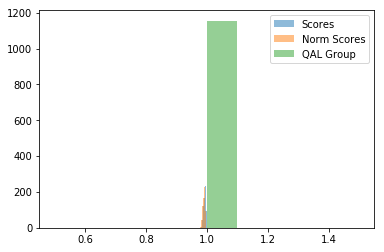

In [14]:
# Define The Score Levels used in QAC

L = 10
Gl = list(range(1,L+1))
Gl[:] = [x / L for x in Gl]


one_group = [[np.zeros(PATCH_COUNT) for x in range(dim_dist)] for y in range(dim_q)]
G = [np.copy(one_group) for x in range(dim_len)]

print(Gl)
print(np.array(G).shape)
print(np.array(norm_scores).shape)

# for i in range(0,dim_len):
#   for d in range(0,dim_dist):
#     for q in range(0,dim_q):
for i in range(ri,i+1):
  for d in range(rd,rd+1):
    for q in range(rq,rq+1):
      for p,score in enumerate(norm_scores[i][d][q]):
        for score_l in Gl:
          if score <= score_l:
            G[i][d][q][p] = score_l
            break

plt.hist(scores[ri][rd][rq], alpha=0.5, label='Scores')
plt.hist(norm_scores[ri][rd][rq], alpha=0.5, label='Norm Scores')
plt.hist(G[ri][rd][rq], alpha=0.5, label='QAL Group')
plt.legend(loc='upper right')
plt.show()

## Convolutional network with Keras and TPUs

### Prepare the training data

In [22]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(all_patches, all_scores, test_size=0.33, shuffle= True)

print(np.array(all_patches).shape)
print(np.array(all_scores).shape)

print(np.array(x_train).shape)
print(np.array(y_train).shape)

print(np.array(x_valid).shape)
print(np.array(y_valid).shape)
#Sigmas: [0.2, 2.0, 4.0]

# def all_filtered_patches(all_patches, sigma):
#   all_filtered = []
#   for i in tqdm(range(len(all_patches))):
#     patch = all_patches[i]
#     gray_patch = color.rgb2gray(patch)
#     filtered = dog(gray_patch, sigma)
#     all_filtered.append(filtered)
#   return all_filtered
# filtered_02 = all_filtered_patches(all_patches, 0.2)
# filtered_20 = all_filtered_patches(all_patches, 2.0)
# filtered_40 = all_filtered_patches(all_patches, 4.0)
    
  

(86700, 15, 15, 3)
(86700,)
(58089, 15, 15, 3)
(58089,)
(28611, 15, 15, 3)
(28611,)


### Declare the model

In [24]:
# The model, based on https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb#scrollTo=Zo-Yk6LFGfSf

import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

AttributeError: ignored